In [31]:
# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#modeling tools
import statsmodels.api as sm

import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, auc, roc_auc_score, roc_curve, log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

%matplotlib inline
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

pd.set_option('display.min_row', 25)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 300)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
collisions = pd.read_csv('../data/processed/collisions_feateng.csv', index_col='OBJECTID', low_memory=False)
intersections_n = pd.read_pickle('../data/processed/intersection_w_normalization.pkl')
traffic_signals = pd.read_csv('../data/Traffic_Signals.csv')

In [24]:
print('Shape of traffic signals dataframe: ', traffic_signals.shape)
traffic_signals.head(2)

Shape of traffic signals dataframe:  (1113, 63)


,OBJECTID,COMPKEY,COMPTYPE,UNITID,DESCRIPTION,UNITDESC,SEGKEY,INTKEY,INT_UNITID,SIGNAL_TYPE,SIGNAL_MAINT_DIST,INSTALL_DATE,ADDDTTM,MODDTTM,OWNERSHIP,CONDITION,CONDITION_ASSESSMENT_DATE,CURRENT_STATUS,CURRENT_STATUS_DATE,ARTERIAL_CLASS,MAINT_AGREE,MAINT_BY,INT_SIGNAL_TYPE_CD,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,PEDAUDIODEVICEYN,PEDSIGNALYN,PH_MODELTYPE,PP_MODELTYPE,PP_QUANTITY,PEDHDFIRSTINSTALLDT,PH_QUANTITY,PEDAUDIOINSTALLDT,BIKESIGNALHDYN,ASBLT,HALFSIGNALYN,METEREDYN,LTTURNSIGNALYN,LTPROTECTEDPERMYN,LTPROTECTEDYN,RTTURNSIGNALYN,RTPROTECTEDPERMYN,RTPROTECTEDYN,LTFIRSTINSTALLDT,LTREMOVEDT,RTFIRSTINSTALLDT,RTREMOVEDT,DETDEVSTOPBARYN,DETDEVADVANCEDYN,DETDEVSYSTEMYN,CABMODELTYPECD,COMCONNTYPECD,MMUMODELTYPECD,PE_MODELTYPE,PI_MODELTYPE,INSTALLERCD,JOINTOWNERSHIPYN,CO_MODELTYPE,MMUMANCD,MMUINSTALLDT,LASTSIGNALOPTDT,PEDPSHINSTALLDT,NUM_ATTACHMENTS
0,1,272753,74,SGL-278,0.0,GREENWOOD AVE N AND N 80TH ST,1,24282,4521,SEMI,NORTH,1970/01/01 00:00:00+00,2005/03/17 17:11:06+00,2019/02/15 00:00:00+00,SDOT,GOOD,2008/03/06 00:00:00+00,INSVC,2008/12/15 00:00:00+00,2.0,NaN,,CITY,DISTRICT6,,N,N,LEDCD,NaN,NaN,1970/01/01 00:00:00+00,8,1970/01/01 00:00:00+00,N,NaN,N,N,Y,Y,N,N,N,N,2011/10/06 00:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,Y,N,N,3TS1,,NSM-12,NaN,NaN,,N,"LC8000, LMD9200",EDI,2019/02/12 00:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,0
1,2,272754,74,SGL-669,0.0,7TH AVE AND WESTLAKE AVE,1,29542,39139,PRE,DOWNTOWN,1970/01/01 00:00:00+00,2005/03/17 17:11:06+00,2020/04/01 00:00:00+00,SDOT,GOOD,2008/09/18 00:00:00+00,INSVC,2008/12/15 00:00:00+00,1.0,NaN,,CITY,DISTRICT7,,N,N,LEDCD,NaN,NaN,1970/01/01 00:00:00+00,8,1970/01/01 00:00:00+00,N,NaN,N,N,N,N,N,N,N,N,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,N,N,N,2,COPPER,NSM-12,OPT,NaN,,Y,"M34, , M52, M60-ATC",EDI,2020/03/05 00:00:00+00,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,0


In [21]:
print('Shape of intersections dataframe: ', intersections_n.shape)
intersections_n.head()

Shape of intersections dataframe:  (37104, 7)


,intkey,name,year,signal_type,arterial_class,subarea,risk
0,29745.0,BROADWAY AND E PIKE ST,2007,CITY,2.0,E,0.000495
1,29745.0,BROADWAY AND E PIKE ST,2008,CITY,2.0,E,0.000253
2,29745.0,BROADWAY AND E PIKE ST,2009,CITY,2.0,E,0.000351
3,29745.0,BROADWAY AND E PIKE ST,2010,CITY,2.0,E,0.000170
4,29745.0,BROADWAY AND E PIKE ST,2011,CITY,2.0,E,0.000059


In [27]:
len(np.intersect1d(intersections_n['intkey'].unique(), traffic_signals['INTKEY'].unique()))

865

In [28]:
traffic_signals['INT_SIGNAL_TYPE_CD'].value_counts()

CITY        898
HALFPED      98
NONE         58
STATE        28
MIDXWALK     15
              9
FS            7
Name: INT_SIGNAL_TYPE_CD, dtype: int64

In [29]:
intersections_n['signal_type'].value_counts()

NONE        26616
CITY         9144
HALFPED       936
STATE         276
FS             72
MIDXWALK       36
               24
Name: signal_type, dtype: int64

### Collisions Data

In [41]:
len(np.intersect1d(intersections_n['intkey'].unique(), collisions['INTKEY'].unique()))

3092

In [39]:
print('Shape of collisions dataframe: ', collisions.shape)
collisions.drop(columns='Unnamed: 0', inplace=True)
collisions.head()

Shape of collisions dataframe:  (194304, 43)


,Datetime,X,Y,INCKEY,ADDRTYPE,INTKEY,LOCATION,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,UNDERINFL,ST_COLCODE,CROSSWALKKEY,SPEEDING_Y,INATTENTIONIND_Y,HITPARKEDCAR_Y,PEDROWNOTGRNT_Y,WEATHER_Adverse,WEATHER_Good,WEATHER_Unknown,ROADCOND_Adverse,ROADCOND_Dry,ROADCOND_Unknown,LIGHTCOND_Dark,LIGHTCOND_Daylight,LIGHTCOND_Unknown,LIGHTCOND_VeryDark,SEVERITYCODE_Injury,SEVERITYCODE_PropertyDamage,SEVERITYCODE_Unknown,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
OBJECTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11627,2004-01-01 00:00:00,NaN,NaN,25040,Block,NaN,BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N,2,0,0,2,1,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,0,13,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,"(47.687805803319904, -122.37545723173001)",0.062183,0.500988,0.063781,0.083897
12525,2004-01-01 00:00:00,-122.318760,47.604359,24635,Block,NaN,E ALDER ST BETWEEN 10TH AVE AND 11TH AVE,2,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),16.0,0,32,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,"(47.7191338070879, -122.29531896585699)",0.015159,0.408913,0.137101,0.001891
14172,2004-01-01 00:00:00,-122.320780,47.614076,26463,Intersection,29745.0,BROADWAY AND E PIKE ST,4,0,0,2,1,0,0,2004/01/01 00:00:00+00,At Intersection (intersection related),11.0,0,28,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,"(47.6920510510355, -122.360659037339)",0.096524,0.257162,0.126424,0.092283
6538,2004-01-01 00:00:00,-122.383351,47.529183,19530,Block,NaN,SW ROSE ST BETWEEN 39TH AVE SW AND 41ST AVE SW,2,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,0,32,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,"(47.7196056381102, -122.35621791966899)",0.289216,0.346730,0.156457,0.024229
9665,2004-01-01 00:00:00,-122.329974,47.708637,22520,Block,NaN,N NORTHGATE WAY BETWEEN CORLISS AVE N AND 1ST AVE NE,1,0,0,1,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),28.0,0,50,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,"(47.6768825661541, -122.36250907509199)",0.059942,0.443346,0.061665,0.063178


### Data Prep

In [43]:
collisions.head(2)

,Datetime,X,Y,INCKEY,ADDRTYPE,INTKEY,LOCATION,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,UNDERINFL,ST_COLCODE,CROSSWALKKEY,SPEEDING_Y,INATTENTIONIND_Y,HITPARKEDCAR_Y,PEDROWNOTGRNT_Y,WEATHER_Adverse,WEATHER_Good,WEATHER_Unknown,ROADCOND_Adverse,ROADCOND_Dry,ROADCOND_Unknown,LIGHTCOND_Dark,LIGHTCOND_Daylight,LIGHTCOND_Unknown,LIGHTCOND_VeryDark,SEVERITYCODE_Injury,SEVERITYCODE_PropertyDamage,SEVERITYCODE_Unknown,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
OBJECTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11627,2004-01-01 00:00:00,NaN,NaN,25040,Block,NaN,BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N,2,0,0,2,1,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,0,13,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,"(47.687805803319904, -122.37545723173001)",0.062183,0.500988,0.063781,0.083897
12525,2004-01-01 00:00:00,-122.31876,47.604359,24635,Block,NaN,E ALDER ST BETWEEN 10TH AVE AND 11TH AVE,2,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),16.0,0,32,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,"(47.7191338070879, -122.29531896585699)",0.015159,0.408913,0.137101,0.001891


In [47]:
collisions.columns[collisions.isnull().sum() > 0]

Index(['X', 'Y', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'JUNCTIONTYPE',
       'ST_COLCODE', 'latlon_tup', 'bikerack_dist', 'radar_dist',
       't_circles_dist', 'marked_cross_dist'],
      dtype='object')

In [42]:
collisions.columns

Index(['Datetime', 'X', 'Y', 'INCKEY', 'ADDRTYPE', 'INTKEY', 'LOCATION',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES',
       'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'JUNCTIONTYPE',
       'SDOT_COLCODE', 'UNDERINFL', 'ST_COLCODE', 'CROSSWALKKEY', 'SPEEDING_Y',
       'INATTENTIONIND_Y', 'HITPARKEDCAR_Y', 'PEDROWNOTGRNT_Y',
       'WEATHER_Adverse', 'WEATHER_Good', 'WEATHER_Unknown',
       'ROADCOND_Adverse', 'ROADCOND_Dry', 'ROADCOND_Unknown',
       'LIGHTCOND_Dark', 'LIGHTCOND_Daylight', 'LIGHTCOND_Unknown',
       'LIGHTCOND_VeryDark', 'SEVERITYCODE_Injury',
       'SEVERITYCODE_PropertyDamage', 'SEVERITYCODE_Unknown', 'latlon_tup',
       'bikerack_dist', 'radar_dist', 't_circles_dist', 'marked_cross_dist'],
      dtype='object')

In [352]:
collisions['CROSSWALKKEY'].value_counts()

0         190143
523609        19
520838        15
525567        13
524265        13
523148        11
523699        10
523735        10
521707        10
524029         9
522108         9
521863         9
           ...  
23883          1
24267          1
522046         1
522174         1
522302         1
524353         1
24653          1
523408         1
524609         1
522686         1
631285         1
525500         1
Name: CROSSWALKKEY, Length: 2312, dtype: int64

In [356]:
# crosswalkkey is a column with basically all 0s but then some randomly large ID values. Change those to 1 to indicate a crosswalk

collisions['CROSSWALKKEY'] = collisions['CROSSWALKKEY'].apply(lambda x: 1 if x > 0 else 0)

In [357]:
collisions['CROSSWALKKEY'].value_counts()

0    190143
1      4161
Name: CROSSWALKKEY, dtype: int64

In [437]:
to_drop = ['Datetime', 'X', 'Y', 'INCKEY', 'INTKEY', 'LOCATION',
       'INCDATE','JUNCTIONTYPE','SDOT_COLCODE', 'ST_COLCODE', 'latlon_tup']

data = collisions.copy()

data.drop(columns=to_drop, inplace = True)

In [438]:
data.head()

,ADDRTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,UNDERINFL,CROSSWALKKEY,SPEEDING_Y,INATTENTIONIND_Y,HITPARKEDCAR_Y,PEDROWNOTGRNT_Y,WEATHER_Adverse,WEATHER_Good,WEATHER_Unknown,ROADCOND_Adverse,ROADCOND_Dry,ROADCOND_Unknown,LIGHTCOND_Dark,LIGHTCOND_Daylight,LIGHTCOND_Unknown,LIGHTCOND_VeryDark,SEVERITYCODE_Injury,SEVERITYCODE_PropertyDamage,SEVERITYCODE_Unknown,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
OBJECTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11627,Block,2,0,0,2,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0.062183,0.500988,0.063781,0.083897
12525,Block,2,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0.015159,0.408913,0.137101,0.001891
14172,Intersection,4,0,0,2,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0.096524,0.257162,0.126424,0.092283
6538,Block,2,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0.289216,0.346730,0.156457,0.024229
9665,Block,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0.059942,0.443346,0.061665,0.063178


In [439]:
data.shape

(194304, 31)

In [440]:
# Use 'Unknown' for ADDRTYPE when null, for now. Might change some to different based on JUNCTIONTYPE

data['ADDRTYPE'].fillna('Unknown', inplace=True)
data['ADDRTYPE'].value_counts(dropna=False)

Block           126091
Intersection     65634
Unknown           1824
Alley              755
Name: ADDRTYPE, dtype: int64

In [441]:
data['ADDRTYPE_OHE'] = data['ADDRTYPE'].map({'Unknown':0, 'Alley':1, 'Block':2, 'Intersection':3})
data.drop(columns='ADDRTYPE', inplace=True)

In [442]:
data.dropna(axis=0, inplace=True)
data.isnull().sum()

PERSONCOUNT                    0
PEDCOUNT                       0
PEDCYLCOUNT                    0
VEHCOUNT                       0
INJURIES                       0
SERIOUSINJURIES                0
FATALITIES                     0
UNDERINFL                      0
CROSSWALKKEY                   0
SPEEDING_Y                     0
INATTENTIONIND_Y               0
HITPARKEDCAR_Y                 0
PEDROWNOTGRNT_Y                0
WEATHER_Adverse                0
WEATHER_Good                   0
WEATHER_Unknown                0
ROADCOND_Adverse               0
ROADCOND_Dry                   0
ROADCOND_Unknown               0
LIGHTCOND_Dark                 0
LIGHTCOND_Daylight             0
LIGHTCOND_Unknown              0
LIGHTCOND_VeryDark             0
SEVERITYCODE_Injury            0
SEVERITYCODE_PropertyDamage    0
SEVERITYCODE_Unknown           0
bikerack_dist                  0
radar_dist                     0
t_circles_dist                 0
marked_cross_dist              0
ADDRTYPE_O

In [443]:
# take only rows that involved pedestrians and cyclists
pedcycle = data[(data['PEDCOUNT'] != 0) | (data['PEDCYLCOUNT'] != 0)].copy()

In [444]:
pedcycle.shape

(13895, 31)

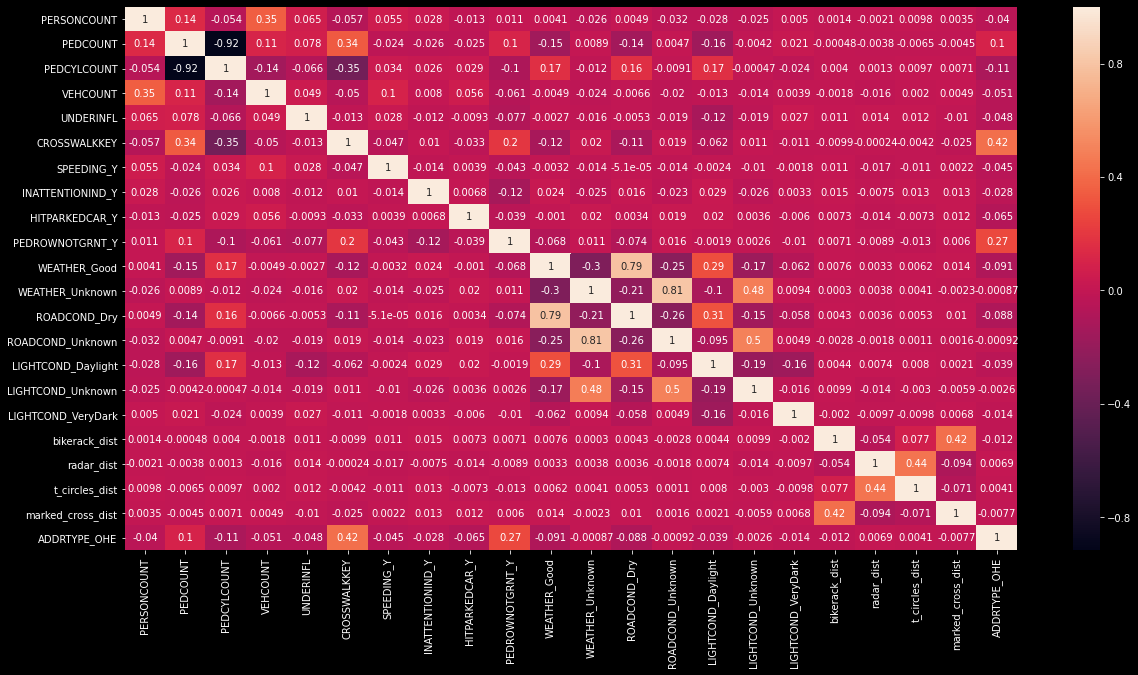

In [481]:
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.heatmap(pedcycle.corr(), annot=True);

plt.savefig('../plots/pedcycle_heatmap.png')

### Target Value

For predicting whether there are  injuries or not (binary), use severitycode_injury.  
Injuries column is essential the same as severitycode_injury, except it has the counts.  
Will need to drop INJURIES, SERIOUSINJURIES, FATALITIES, SEVERITYCODE_PropertyDamage, SEVERITYCODE_Unknown

In [445]:
high_corr_cols = ['WEATHER_Adverse', 'ROADCOND_Adverse', 'LIGHTCOND_Dark']
pedcycle.drop(columns=high_corr_cols, inplace=True)

In [446]:
pedcycle.drop(columns=['INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'SEVERITYCODE_PropertyDamage', 'SEVERITYCODE_Unknown'], inplace=True)

In [447]:
y = pedcycle.pop('SEVERITYCODE_Injury')

## Pedestrian: Train/Test Split

Looking only at the data related to pedestrians.  
Will need to drop 'PERSONCOUNT', 'PEDCYLCOUNT'

In [489]:
p_X = pedcycle.copy()
p_X.drop(columns=['PERSONCOUNT', 'PEDCYLCOUNT', 'PEDCOUNT', 'VEHCOUNT', 'CROSSWALKKEY', 
                  't_circles_dist', 'radar_dist', 'bikerack_dist', 'marked_cross_dist'], inplace=True)

In [490]:
pX_train, pX_test, py_train, py_test = train_test_split(p_X, y, test_size=0.2)

#### Decision Tree Classifier Model

In [485]:
# Parameter Search

p_model1 = DecisionTreeClassifier()

depth_param = np.arange(1, 3, 1)
num_samples_param = np.arange(5,35,10)
parameters = {'max_depth' : depth_param,
             'min_samples_leaf' : num_samples_param}

scorer = make_scorer(log_loss,
                     greater_is_better=False,
                     needs_proba=True)
clf = GridSearchCV(p_model1,
                   parameters,
                   cv=10,
                   scoring=scorer)
clf.fit(pX_train,py_train)

print(f"log loss = {-clf.score(pX_test, py_test)}")
print(f"accuracy = {(clf.predict(pX_test) == py_test).mean()}")

log loss = 0.33283984956585877
accuracy = 0.8956584312784841


In [486]:
print('Best Decision Tree CLassifier parameters: ', clf.best_params_)

Best Decision Tree CLassifier parameters:  {'max_depth': 2, 'min_samples_leaf': 25}


#### Fit Decision Tree Classifier using best parameters

In [487]:
p_dtc_model = DecisionTreeClassifier(max_depth=2, min_samples_leaf=25)

p_dtc_model.fit(pX_train,py_train)

p_pred_proba = p_dtc_model.predict_proba(pX_test)

In [488]:
p_auc_score = roc_auc_score(py_test, p_pred_proba[:, 1])
print('AUC Score DTC-Pedestrian: ', p_auc_score)

AUC Score DTC-Pedestrian:  0.5236669560238627


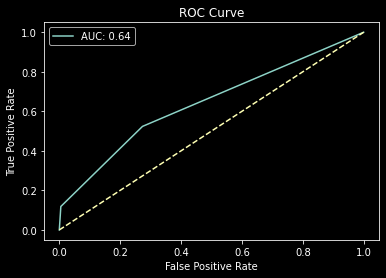

In [218]:
# Plot AUC
# Odd looking, used probability but still sharp

fpr, tpr, thresholds = roc_curve(py_test, p_pred_proba[:, 1])

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label='AUC: {:2.2f}'.format(p_auc_score))
ax.legend(loc='upper left')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--');

#### Random Forest Classifier Model: No parameter change

In [491]:
p_rf = RandomForestClassifier(n_estimators=400)
p_rf.fit(pX_train, py_train)
                                     
# Test Prediction

p_rf_pred = p_rf.predict(pX_test)
p_rf_predproba = p_rf.predict_proba(pX_test)

print(f"log loss = {log_loss(py_test, p_rf_predproba[:, 1])}")
print(f"accuracy = {p_rf.score(pX_test, py_test)}")

log loss = 0.4313866264189108
accuracy = 0.8916876574307305


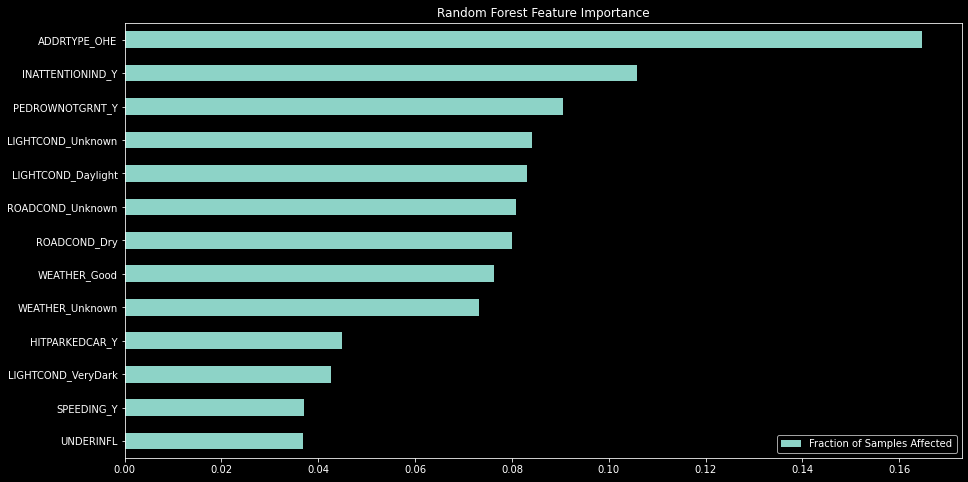

In [492]:
# Plot the feature importance
p_feat_scores = pd.DataFrame({'Fraction of Samples Affected' : p_rf.feature_importances_},
                           index=p_X.columns)
p_feat_scores = p_feat_scores.sort_values(by='Fraction of Samples Affected')
p_feat_scores.plot(kind='barh', figsize=(15,8))
plt.title('Random Forest Feature Importance');

plt.savefig('../plots/rf_featimportance.png')

In [493]:
p_rf_auc_score = roc_auc_score(py_test, p_rf_predproba[:, 1])
print('AUC Score RF-Pedestrian: ', p_rf_auc_score)

AUC Score RF-Pedestrian:  0.5238543628374137


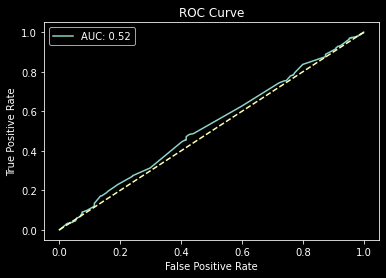

In [494]:
fpr, tpr, thresholds = roc_curve(py_test, p_rf_predproba[:, 1])

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label='AUC: {:2.2f}'.format(p_rf_auc_score))
ax.legend(loc='upper left')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--');